# Deep Convolutional GANs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data', validation_size=0)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


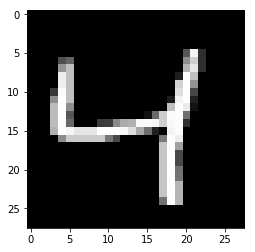

In [3]:
img = mnist.train.images[2]
img = img.reshape((28, 28))
plt.imshow(img, cmap="Greys_r")
plt.show()

### Define handy functions 
Here, I define handy functions to be used to build the generator and the discriminator. 

In [4]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

def conv2d(x, W_size, name, strides=[1, 1, 1, 1]):
    """
    make conv layer
    
    :param x: input to conv layer. the size must match with W_size. 
    :param W_size: list. [filter_width, filter_height, input_channel, output_channel]
    :param strides: list of strides of each dimension as follows. [batch, width, height, channel] 
    :return: returns conv layer with bias b added. 
    """
    W = tf.get_variable(shape=W_size, name=name+"/weight")
    b = tf.get_variable(shape=W_size[3], name=name+"/bias")
    conv = tf.nn.conv2d(input=x, filter=W, strides=strides, padding="SAME")
    return conv + b

### Define inputs. 
There are two inputs needed; one is real image input for discriminator, and one is random noise input for generator. <br>
Real image input is denoted as x, and random noise is z. 

In [5]:
def initialize_inputs(x_size, z_size):
    """
    initialize inputs x and z. 
    
    x is for real data, and z is for random noise for generator. 
    
    :param z_size: size of z vector
    :return x and z 
    """
    x = tf.placeholder(dtype=tf.float32, shape=[None, *x_size], name="input_real")
    z = tf.placeholder(dtype=tf.float32, shape=[None, z_size], name="input_z")
    
    return x, z

### Generator 
Define a generator. <br>
In the conv layer, I will use image resizing to avoid checker board pattern. <br>
ref: https://distill.pub/2016/deconv-checkerboard/


In [6]:
def generator(z, z_size, reuse=False, training=True):
    """
    :param z: a vector with length z_size, where every elements of z is between -1 and 1
    :param z_size: length of the z vector
    :param reuse: boolean. whether to reuse the trained variable of weights. 
    :param training: boolean. whether it is training or not
    :return: creates generator and return the logits and model
    """
    with tf.variable_scope("generator", reuse=reuse):
        # layer 1: fully connected layer 
        # change the length of z such that it fits to conv layer 
        W_fc1 = tf.get_variable(shape=[z_size, 7*7*128], name="fc_weight")
        b_fc1 = tf.get_variable(shape=7*7*128, name="fc_bias")
        h_fc1 = tf.matmul(z, W_fc1) + b_fc1
        # now, (7*7*128, )

        # layer 2: reshape layer 
        reshape2 = tf.reshape(h_fc1, shape=[-1, 7, 7, 128])
        # now, 7 x 7 x 128
        batch_norm2 = tf.layers.batch_normalization(reshape2, training=training)
        relu2 = leaky_relu(batch_norm2)

        # layer 3: conv layer 
        resize3 = tf.image.resize_nearest_neighbor(images=relu2, size=(14, 14))
        # now, 14 x 14 x 128
        conv3 = conv2d(x=resize3, W_size=[5, 5, 128, 64], name="conv3")
        # now, 14 x 14 x 64
        batch_norm3 = tf.layers.batch_normalization(conv3, training=training)
        relu3 = leaky_relu(batch_norm3)

        # layer 4: conv layer 
        resize4 = tf.image.resize_nearest_neighbor(images=relu3, size=(28, 28))
        # now, 28 x 28 x 64
        conv4 = conv2d(x=resize4, W_size=[5, 5, 64, 32], name="conv4")
        # now, 28 x 28 x 32
        batch_norm4 = tf.layers.batch_normalization(conv4, training=training)
        relu4 = leaky_relu(batch_norm4)
        
        # layer 5: output layer 
        logits = conv2d(x=relu4, W_size=[5, 5, 32, 1], name="output")
        model = tf.tanh(logits)
        
        return logits, model
    

### Discriminator 
Defining discriminator 

In [7]:
def discriminator(x, reuse=False, training=True):
    """
    :param x: list [None, 28, 28, 1], where every element is between -1 and 1
    :param reuse: boolean. whether to reuse the trained variable of weights. 
    :param training: boolean. whether it is training or not
    :return: creates discriminator and returns logits and model 
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # layer 1: conv layer 
        conv1 = conv2d(x=x, W_size=[5, 5, 1, 64], strides=[1, 2, 2, 1], name="conv1")
        # now, 14 x 14 x 64
        relu1 = leaky_relu(conv1)
        
        # layer 2: conv layer 
        conv2 = conv2d(x=relu1, W_size=[5, 5, 64, 128], strides=[1, 2, 2, 1], name="conv2")
        # now, 7 x 7 x 128
        batch_norm2 = tf.layers.batch_normalization(conv2, training=training)
        relu2 = leaky_relu(batch_norm2)
        
        # layer 3: reshape 
        reshape3 = tf.reshape(relu2, shape=[-1, 7*7*128])
        
        # layer 4: fc layer 
        W_fc4 = tf.get_variable(shape=[7*7*128, 1], name="fc_weight")
        b_fc4 = tf.get_variable(shape=[1], name="fc_bias")
        logits = tf.matmul(reshape3, W_fc4) + b_fc4
        # now, (1, )
        model = tf.nn.sigmoid(logits)
        
        return logits, model

### Loss function 
Define loss function. 

In [8]:
def loss(x, z, z_size):
    """
    define the loss functions of discriminator and generator 
    
    :param x: real image
    :param z: random noize z 
    :param z_size: size of random noise 
    :return: d_loss, g_loss
    """
    # generate fake images 
    g_logits, g_model = generator(z=z, z_size=z_size)
    # using real and fake images, get outputs of discriminator  
    d_real_logits, d_real_model = discriminator(x=x)
    d_fake_logits, d_fake_model = discriminator(x=g_model, reuse=True)
    
    # define discriminator loss
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
    d_loss = d_real_loss + d_fake_loss
    
    # define generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    
    return d_loss, g_loss
        

### Optimizer 

In [15]:
def optimizer(d_loss, g_loss, learning_rate, beta1):
    # get variables to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

### build networks 

In [16]:
tf.reset_default_graph()

# define hyperparameters
z_size = 100
learning_rate = 0.0002
x_size = [28, 28, 1]
beta1 = 0.5

# initializ inputs
x, z = initialize_inputs(x_size=x_size, z_size=z_size)

# define loss function 
d_loss, g_loss = loss(x=x, z=z, z_size=z_size)

# define optimizers 
d_opt, g_opt = optimizer(d_loss, g_loss, learning_rate, beta1)

### Training

epoch 0;  0.999815 1.17613
epoch 1;  1.05496 0.849435
epoch 2;  1.05645 0.857162
epoch 3;  1.3655 0.444595
epoch 4;  1.16924 0.76075
epoch 5;  1.08678 0.982158
epoch 6;  1.1902 0.922898
epoch 7;  1.16872 0.661942
epoch 8;  1.13051 0.853592
epoch 9;  1.10982 0.850819


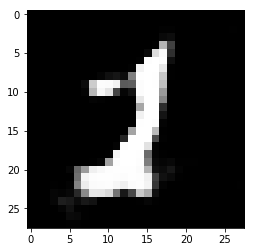

epoch 10;  1.13803 0.914489
epoch 11;  1.15561 0.771027
epoch 12;  1.17064 0.793182
epoch 13;  1.1437 1.36632
epoch 14;  1.12362 0.841807
epoch 15;  1.1815 1.29247
epoch 16;  1.09336 0.844089
epoch 17;  1.21183 1.45049
epoch 18;  1.19697 1.05386
epoch 19;  1.06463 0.882888


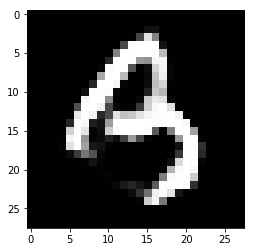

epoch 20;  1.12331 1.02954
epoch 21;  1.04908 0.963506
epoch 22;  1.11677 1.01414
epoch 23;  1.12551 0.909681
epoch 24;  1.14278 1.24615
epoch 25;  1.25807 0.518961
epoch 26;  1.13434 1.01941
epoch 27;  1.08957 1.44827
epoch 28;  1.1548 0.93858
epoch 29;  1.21331 0.688559


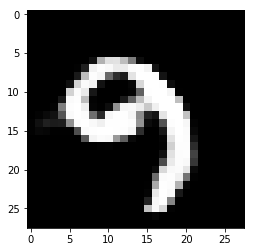

epoch 30;  1.15018 0.93212
epoch 31;  1.18202 0.761943
epoch 32;  1.06808 0.887574
epoch 33;  1.16396 1.13907
epoch 34;  1.16108 1.26089
epoch 35;  1.16422 0.840726
epoch 36;  1.1782 1.31892
epoch 37;  1.15071 0.885001
epoch 38;  1.09529 0.769837
epoch 39;  1.16229 0.992386


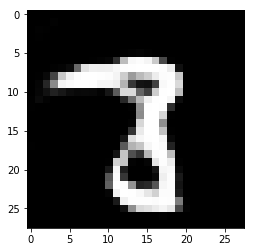

epoch 40;  1.15614 0.981703
epoch 41;  1.19086 1.14165
epoch 42;  1.19081 0.703281
epoch 43;  1.11646 0.942188
epoch 44;  1.19631 0.718918
epoch 45;  1.20278 0.943816
epoch 46;  1.15484 0.798251
epoch 47;  1.11296 0.885122
epoch 48;  1.20817 1.08361
epoch 49;  1.15466 0.874245


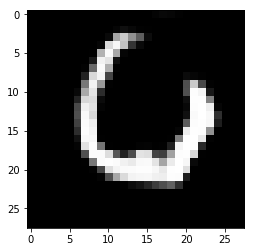

epoch 50;  1.13463 0.869778
epoch 51;  1.12683 0.758139
epoch 52;  1.17908 0.86656
epoch 53;  1.21969 0.777467
epoch 54;  1.19477 0.787907
epoch 55;  1.23252 0.612906
epoch 56;  1.19688 0.652385
epoch 57;  1.16364 0.920381
epoch 58;  1.20325 1.07921
epoch 59;  1.10448 1.01081


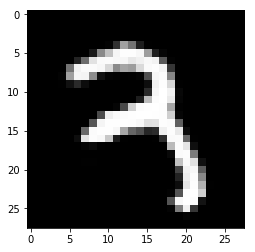

epoch 60;  1.32686 0.543725
epoch 61;  1.17523 1.00844
epoch 62;  1.16917 1.01644
epoch 63;  1.13146 0.952305
epoch 64;  1.18487 0.793517
epoch 65;  1.1328 0.977837
epoch 66;  1.16578 0.693855
epoch 67;  1.20111 1.08351
epoch 68;  1.11911 0.956689
epoch 69;  1.12554 0.901125


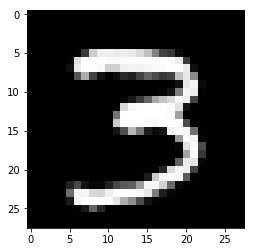

epoch 70;  1.18171 0.90906
epoch 71;  1.19689 0.845663
epoch 72;  1.13362 1.21757
epoch 73;  1.18215 0.678
epoch 74;  1.15764 1.22289
epoch 75;  1.21483 0.774348
epoch 76;  1.13722 0.888693
epoch 77;  1.18152 0.784023
epoch 78;  1.19359 0.935521
epoch 79;  1.18269 0.909382


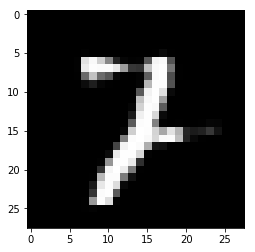

epoch 80;  1.20209 1.18455
epoch 81;  1.11972 1.07938
epoch 82;  1.1736 0.793274
epoch 83;  1.162 0.789994
epoch 84;  1.21447 1.1905
epoch 85;  1.19818 0.872355
epoch 86;  1.19829 0.719631
epoch 87;  1.20152 0.821029
epoch 88;  1.25252 0.68098
epoch 89;  1.10198 1.25906


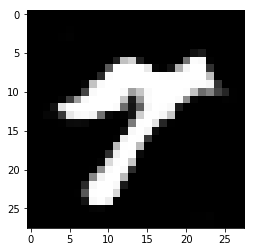

epoch 90;  1.1125 1.07844
epoch 91;  1.18065 0.924131
epoch 92;  1.11492 0.942934
epoch 93;  1.18786 0.686932
epoch 94;  1.17413 0.777177
epoch 95;  1.16448 0.957973
epoch 96;  1.16008 0.981227
epoch 97;  1.1577 0.817573
epoch 98;  1.26602 0.63036
epoch 99;  1.19536 0.728209


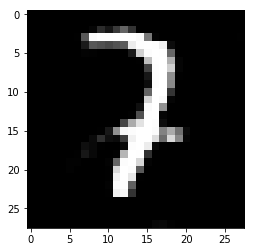

In [21]:
epochs = 100
batch_size = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(batch_size):
            # get imgs, reshape and rescale to pass to discriminator
            batch = mnist.train.next_batch(batch_size)
            real_imgs = batch[0].reshape(-1, 28, 28, 1)
            real_imgs = real_imgs*2 - 1

            # generate random vector for z 
            rand_noise = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            
            # update discriminator and generator 
            sess.run(g_opt, feed_dict={x:real_imgs, z:rand_noise})
            sess.run(d_opt, feed_dict={x:real_imgs, z:rand_noise})
            
        # print training losses 
        train_loss_d = d_loss.eval({x:real_imgs, z:rand_noise})
        train_loss_g = g_loss.eval({z:rand_noise})
        print("epoch " + str(e) + "; ", train_loss_d, train_loss_g)
        
        # print generated images 
        if (e+1)%10 == 0:
            sample_z = np.random.uniform(-1, 1, size=(1, z_size))
            g_logits, g_imgs = sess.run(generator(z, z_size, reuse=True), feed_dict={z: sample_z})
            g_imgs = g_imgs[0, :, :, 0]
            plt.imshow(g_imgs, cmap="Greys_r")
            plt.show()
        
    